# Import Library

In [ ]:
!git clone https://github.com/ezaaputra/indonlu.git

!pip install emoji
!pip install transformers

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

# NLP
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#Model IndoBERT
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn

fatal: destination path 'indonlu' already exists and is not an empty directory.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Import Data

In [31]:
data = pd.read_csv('/content/midikriing_reviews_labeled (1).csv')
data

,content,score,sentiment
0,aplikasinya superr lemotttt!!!!!!!!!!,1,-1
1,"pesanan tidak diantarkan, sudah dibayar pula, ...",1,-1
2,Ease Of Use,5,1
3,berbagi pengalaman penggunaan midi kring vs kl...,1,-1
4,aplikasi sejauh ini sudah bagus hanya saja lum...,4,1
...,...,...,...
8771,Sangat mmbantu dalam pembelanjaan,5,1
8772,Mantaap,5,1
8773,"Bismillah ,",5,1
8774,Belanja di alfamidi lebih mudah pakai aplikasi...,5,1


# EDA

In [32]:
data = data.drop_duplicates()
data

,content,score,sentiment
0,aplikasinya superr lemotttt!!!!!!!!!!,1,-1
1,"pesanan tidak diantarkan, sudah dibayar pula, ...",1,-1
2,Ease Of Use,5,1
3,berbagi pengalaman penggunaan midi kring vs kl...,1,-1
4,aplikasi sejauh ini sudah bagus hanya saja lum...,4,1
...,...,...,...
8769,Mantap 😻,5,1
8770,"Mantab alfamidi,belanja tinggal klik bayar,gra...",5,1
8771,Sangat mmbantu dalam pembelanjaan,5,1
8773,"Bismillah ,",5,1


In [33]:
kamus_alay = pd.read_csv('/content/kamus_alay.csv')
kamus_alay

,slang,formal
0,woww,wow
1,aminn,amin
2,met,selamat
3,netaas,menetas
4,keberpa,keberapa
...,...,...
3258,boz,bos
3259,mayan,lumayan
3260,ribed,ribet
3261,ntapz,mantap


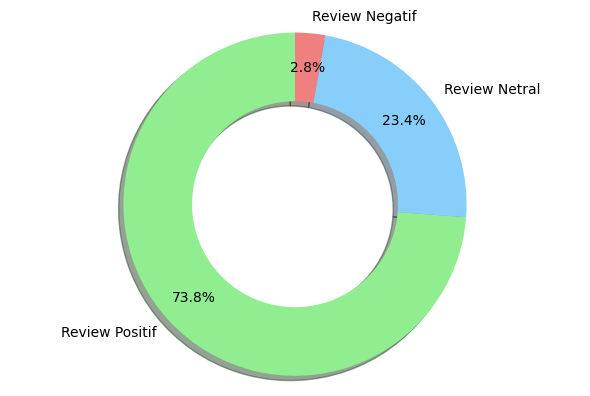

In [34]:
# Function to make a donut chart
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%',
           startangle = angle, pctdistance=0.8, explode = explode,
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')
    plt.tight_layout()

# Plot arguments
sizes = data.sentiment.value_counts()
labels = ['Review Positif', 'Review Netral', 'Review Negatif']
colors = ['lightgreen', 'lightskyblue', 'lightcoral']
explode = (0,0,0)

# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)

plt.show()

# Text Preprocessing

## Data Cleaning & Case Folding

Tahapan preprocessing teks dilakukan dengan case folding menggunakan fungsi lower() untuk menyamakan penggunaan huruf kapital, karena data yang diperoleh sering tidak konsisten. Setelah itu dilakukan pembersihan teks menggunakan regular expression untuk menghapus angka, simbol tertentu, URL, username (@username), hashtag (#), spasi berlebih, tanda baca, emoji, serta pengulangan karakter berlebihan sehingga teks menjadi lebih bersih, konsisten, dan siap digunakan untuk analisis lebih lanjut.

In [35]:
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# hapus karakter yang berulang
def repeatcharClean(content):
  for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long
      content = content.replace(char,character[i])
      charac_long -= 1
  return content

def clean_review(content):
  # ubah content menjadi huruf kecil
  content = content.lower()
  # ubah enter menjadi spasi
  content = re.sub(r'\n', ' ', content)
  # hapus emoji
  content = emoji.demojize(content)
  content = re.sub(':[A-Za-z_-]+:', ' ', content) # delete emoji
  # hapus emoticon
  content = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', content)
  # hapus link
  content = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", content)
  # hapus usename
  content = re.sub(r"@[^\s]+[\s]?", ' ', content)
  # hapus hashtag
  content = re.sub(r'#(\S+)', r'\1', content)
  # hapus angka dan beberapa simbol
  content = re.sub('[^a-zA-Z,.?!]+',' ',content)
  # hapus karakter berulang
  content = repeatcharClean(content)
  # clear spasi
  content = re.sub('[ ]+',' ',content)
  return content

def preprocess_v1(data):
  df_pp = data.copy()
  df_pp.content = df_pp.content.map(clean_review)

  # delete empty row
  df_pp.content.replace('', np.nan, inplace=True)
  df_pp.content.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['content'], inplace=True)
  return df_pp

df_v1 = preprocess_v1(data)

/tmp/ipython-input-2180390043.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pp.content.replace('', np.nan, inplace=True)
/tmp/ipython-input-2180390043.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

## Tokenizing & Normalization

Tahapan preprocessing teks dilakukan dengan regular expression untuk menghapus karakter yang tidak diperlukan, kemudian kalimat dipecah menjadi daftar kata menggunakan fungsi word_tokenize dari library NLTK. Selanjutnya dilakukan normalisasi, yaitu mengubah kata tidak baku atau kata gaul menjadi bentuk baku sesuai ejaan.

Normalisasi penting karena banyak kata seperti tdk, dmn, cpt, ga, enggak, ngga, dan gak yang memiliki makna sama, namun tanpa normalisasi sistem akan menganggapnya sebagai kata berbeda. Dengan tahapan ini, teks menjadi lebih konsisten dan siap digunakan untuk analisis lebih lanjut.

In [39]:
nltk.download('punkt_tab')

normalize_word_dict = {}
for index, row in kamus_alay.iterrows():
    if row.iloc[0] not in normalize_word_dict:
        normalize_word_dict[row.iloc[0]] = row.iloc[1]

def normalize_review(content):
  # tokenize
  list_content = word_tokenize(content)
  # ubah bahasa alay
  list_content = [normalize_word_dict[term] if term in normalize_word_dict else term for term in list_content]
  # gabung kembali kalimat
  content = " ".join(list_content)
  return content

def preprocess_v2(data):
  df_pp = data.copy()
  df_pp.content = df_pp.content.map(normalize_review)

  # delete empty row
  df_pp.content = df_pp.content.replace('', np.nan)
  df_pp.content = df_pp.content.replace(' ', np.nan)
  df_pp.dropna(subset=['content'], inplace=True)
  return df_pp

# take a while
df_v2  = preprocess_v2(df_v1)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Dataset Splitting

In [42]:
# train val split
train_set, val_set = train_test_split(df_v2, test_size=0.3, stratify=df_v2.sentiment, random_state=1)
val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.sentiment, random_state=1)

print(f'Train shape: {train_set.shape}')
print(f'Val shape: {val_set.shape}')
print(f'Test shape: {test_set.shape}')

# export to tsv
train_set.to_csv('train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('test_set.tsv', sep='\t', header=None, index=False)

Train shape: (5054, 3)
Val shape: (1451, 3)
Test shape: (715, 3)
